In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchtext.vocab import GloVe
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle
from utils import TextEmotionDataset

In [18]:
import os
import pickle

# Define the base path relative to the notebook's location
base_path = os.getcwd() 

# Paths to your files
tokenizer_path = os.path.join(base_path, 'tokenizer_csv.pkl')
processed_data_path = os.path.join(base_path, 'processed_data_csv.pkl')
label_encoder_path = os.path.join(base_path, 'label_encoder_csv.pkl')

# Loading the files
# Load the tokenizer
with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)

# Load the processed data
with open(processed_data_path, 'rb') as file:
    X_train_pad, X_val_pad, X_test_pad, y_train, y_val, y_test, max_seq_length = pickle.load(file)

# Load the label encoder
with open(label_encoder_path, 'rb') as file:
    label_encoder = pickle.load(file)

# Create datasets and dataloaders for training, validation, and testing
train_dataset = TextEmotionDataset(X_train_pad, y_train)
val_dataset = TextEmotionDataset(X_val_pad, y_val)  # Assuming you have a validation dataset
test_dataset = TextEmotionDataset(X_test_pad, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Assuming the same batch size as train_loader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [19]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, n_filters, filter_sizes, drop_prob=0.5):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, n_filters, (fs, embedding_dim)) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_size)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # add channel (1, L, D)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)
        x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)
        logit = self.fc(x)
        return logit

# Parameters
vocab_size = len(tokenizer.word_index) + 1
output_size = len(label_encoder.classes_)
embedding_dim = 100
n_filters = 100
filter_sizes = [3, 4, 5]

# Instantiate the model, loss, and optimizer
model1 = CNNModel(vocab_size, output_size, embedding_dim, n_filters, filter_sizes)

In [20]:
# GloVe embeddings
vocab_size = len(tokenizer.word_index) + 1
glove = GloVe(name='6B', dim=100)
embedding_matrix = torch.zeros((vocab_size, glove.dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = glove.vectors[glove.stoi[word]] if word in glove.stoi else torch.randn(glove.dim)
    embedding_matrix[index] = embedding_vector

class BiLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, pretrained_embeddings, drop_prob=0.5):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        # Apply dropout only if n_layers > 1
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob if n_layers > 1 else 0, 
                            batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        soft_out = self.softmax(out)
        return soft_out

# Instantiate the model with the embedding matrix
model2 = BiLSTM(
    vocab_size, 
    len(label_encoder.classes_), 
    100,  # embedding dimension
    256,  # hidden dimension
    2,    # number of LSTM layers
    embedding_matrix  # pretrained GloVe embeddings
)

In [21]:
# Attention module
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.main = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 1)
        )

    def forward(self, lstm_output):
        attn_weights = self.main(lstm_output)
        attn_weights = torch.softmax(attn_weights.squeeze(2), dim=1)
        return attn_weights

class AttBiLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, pretrained_embeddings, drop_prob=0.5):
        super(AttBiLSTM, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob if n_layers > 1 else 0, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(drop_prob)
        self.attention = Attention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        attn_weights = self.attention(lstm_out)
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), lstm_out).squeeze(1)
        out = self.dropout(attn_applied)
        out = self.fc(out)
        soft_out = self.softmax(out)
        return soft_out

model3 = AttBiLSTM(vocab_size, len(label_encoder.classes_), 100, 256, 2, embedding_matrix)

In [22]:
# import and compare models

model1.load_state_dict(torch.load('/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/cnn_te.pth'))
model2.load_state_dict(torch.load('/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/bi_lstm_te.pth'))
model3.load_state_dict(torch.load('/Users/advait/Desktop/gitpositories/SC4001-Assignment-2/Text-Emotion-Recognition/saved_models/att_bi_lstm_te.pth'))

<All keys matched successfully>

In [23]:
# Evaluate the models on the test set

def evaluate(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            text, target = batch
            output = model(text)
            y_true.extend(target.tolist())
            y_pred.extend(torch.argmax(output, 1).tolist())
    return y_true, y_pred

# Evaluate the models
y_true1, y_pred1 = evaluate(model1, test_loader)
y_true2, y_pred2 = evaluate(model2, test_loader)
y_true3, y_pred3 = evaluate(model3, test_loader)

# Print classification reports
print('CNN')
print(classification_report(y_true1, y_pred1, target_names=label_encoder.classes_))
print('BiLSTM')
print(classification_report(y_true2, y_pred2, target_names=label_encoder.classes_))
print('AttBiLSTM')
print(classification_report(y_true3, y_pred3, target_names=label_encoder.classes_))

CNN
              precision    recall  f1-score   support

   happiness       0.43      0.21      0.28      1034
        love       0.42      0.51      0.46       809
     neutral       0.41      0.58      0.48      1683
     sadness       0.43      0.19      0.26      1107
       worry       0.40      0.48      0.43      1630

    accuracy                           0.41      6263
   macro avg       0.42      0.39      0.38      6263
weighted avg       0.42      0.41      0.39      6263

BiLSTM
              precision    recall  f1-score   support

   happiness       0.34      0.55      0.42      1034
        love       0.48      0.38      0.42       809
     neutral       0.47      0.49      0.48      1683
     sadness       0.46      0.08      0.13      1107
       worry       0.41      0.51      0.45      1630

    accuracy                           0.42      6263
   macro avg       0.43      0.40      0.38      6263
weighted avg       0.43      0.42      0.40      6263

AttBiLSTM
 

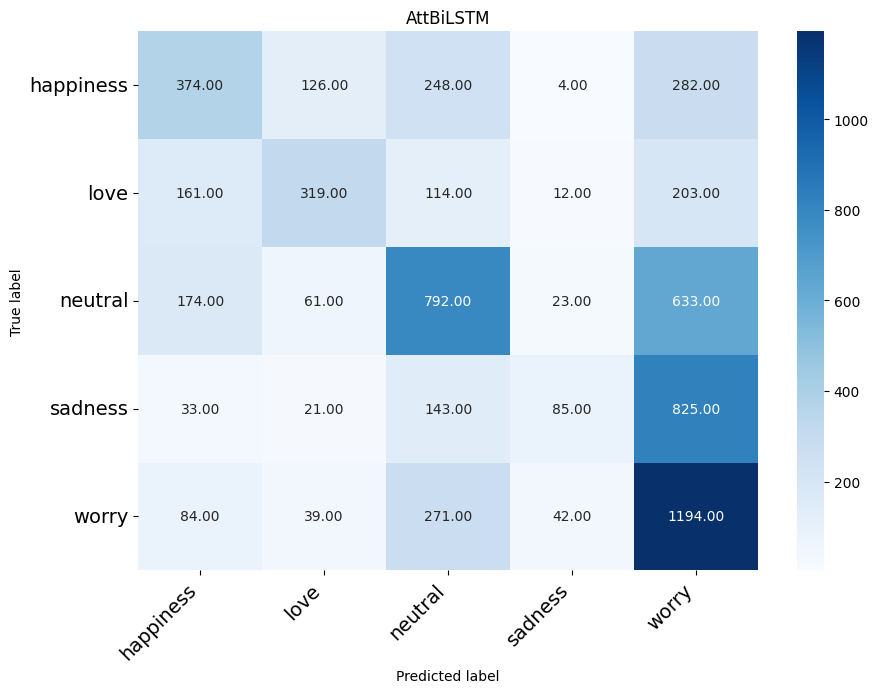

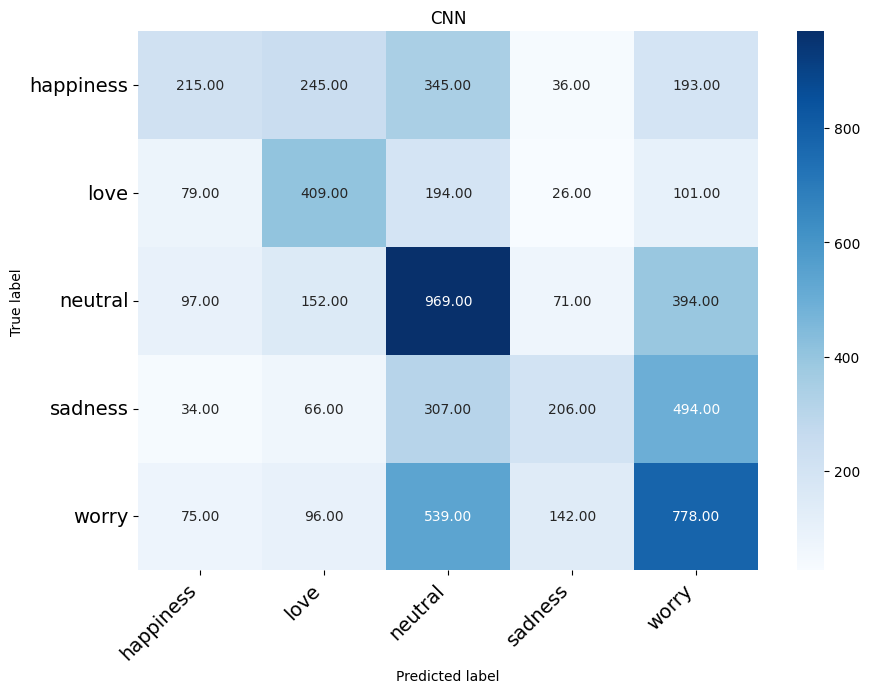

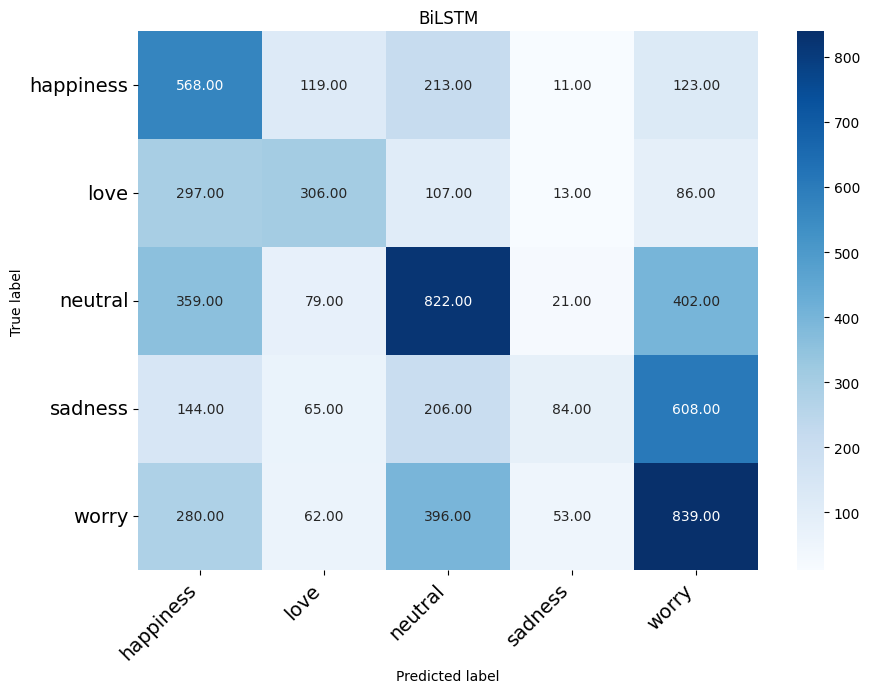

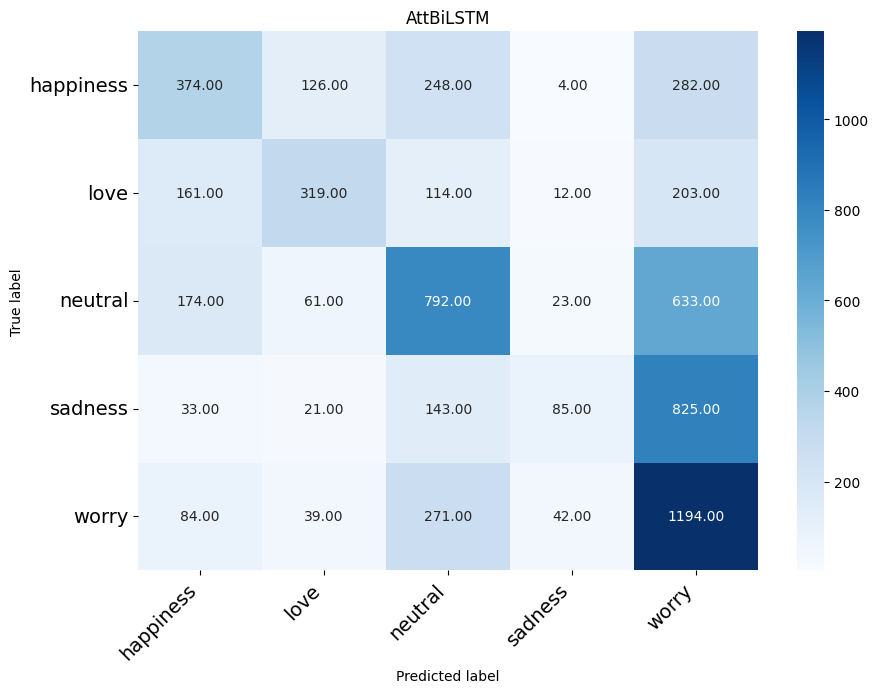

In [26]:
# plot confusion matrix for each models predictions on test set using seaborn

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    fig = plt.figure(figsize=(10, 7))
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f", cmap=cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    return fig

# Plot the confusion matrices
plot_confusion_matrix(y_true1, y_pred1, label_encoder.classes_, title='CNN')
plot_confusion_matrix(y_true2, y_pred2, label_encoder.classes_, title='BiLSTM')
plot_confusion_matrix(y_true3, y_pred3, label_encoder.classes_, title='AttBiLSTM')



In [25]:
# for bilstm, get the indexes of the cases where worry is true but happiness is predicted

worry_true = []
happiness_pred = []
for i in range(len(y_true2)):
    if y_true2[i] == 4 and y_pred2[i] == 0:
        worry_true.append(i)
    if y_true2[i] == 4 and y_pred2[i] == 2:
        happiness_pred.append(i)

# print the text of the cases where worry is true but happiness is predicted

for i in worry_true:
    print(tokenizer.sequences_to_texts([X_test_pad[i]]))


['getting ready for my graduation party id much rather be at hello marquee or dane cook']
["amysav83 you'll be fine don't worry good luck again"]
['ilovesarai i think i am going to do lennys i dont know ahh lol i hate making decsions']
["freshypanda i work with drunk golfers it can be exciting it wasn't bad yours sir"]
['finished dinner apple bees off to freds in pb for drinks']
["wait damonandrew and uchenna3 electrik red or richgirl i'm a sucker for the later"]
['david tennant yes watching season 2 all evening wish i could get bbc2']
['waiting for the denver game to come on but i dont think their gonna win it lakers suck lol p come on denver']
['solaravada damn lol on friday its now saturday here lol im in australia']
['jordanknight off to bed with fingers and toes and everything crossed u pick me lol hope ur well and got back safe poor jon xx']
["aaaale haha i'll let you know how the show was hope here in romania they will show it on mtv sunday morning i have an exam"]
["destroytoda